# MAI391_Project - Email spam detection

## Import libraries and Load data

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,log_loss
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import pickle as pkl
from collections import defaultdict
from collections import Counter
from nltk.stem import PorterStemmer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [58]:
df = pd.read_csv('./data/email_spam.csv', encoding='latin-1')

In [59]:
df.shape

(5572, 5)

In [60]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


## Clean Data & Vizualizing Data

### Clean Data

In [61]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [62]:
# Drop Columns
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [63]:
# Rename Columns
df.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)

df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [64]:
# Check for missing values
df.isnull().sum()

label      0
message    0
dtype: int64

In [65]:
# Check for duplicates
df.duplicated(subset='message').sum()

403

In [66]:
# Delete duplicates
df.drop_duplicates(subset='message',keep='first', inplace=True)

df.duplicated(subset='message').sum()

0

In [67]:
# Shape of the data after cleaning
df.shape

(5169, 2)

In [68]:
# Encode the label
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

df

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [69]:
df[df['label']==1]

,label,message
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
5,1,FreeMsg Hey there darling it's been 3 week's n...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...
11,1,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [70]:
df.loc[11]['message']

'SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info'

### Vizualizing Data


Percentage of ham and spam values:
label
0    87.366996
1    12.633004
Name: proportion, dtype: float64


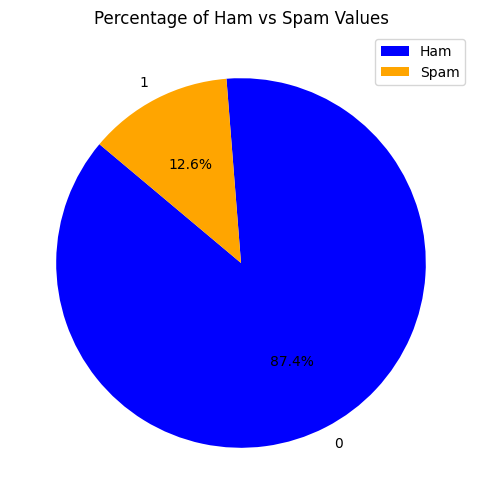

In [71]:
# Calculate the percentage of ham and spam values
percentage = df['label'].value_counts(normalize=True) * 100
print("\nPercentage of ham and spam values:")
print(percentage)

# Plot the pie chart
plt.figure(figsize=(8, 6))
percentage.plot(kind='pie', autopct='%1.1f%%', colors=['blue', 'orange'], startangle=140)
plt.title('Percentage of Ham vs Spam Values')
plt.ylabel('')  # Hide the y-label
plt.legend(['Ham', 'Spam'], loc='upper right')
plt.show()

## Anylizing the data

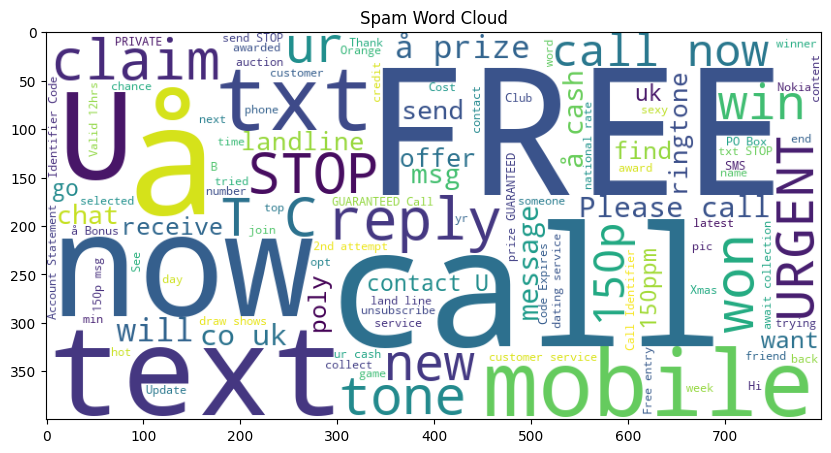

In [72]:
# Spam word cloud
wc = WordCloud(width=800, height=400, max_words=200,min_font_size=10, background_color='white')
spam_wc = wc.generate(' '.join(df[df['label'] == 1]['message']))
plt.figure(figsize=(10, 10))
plt.imshow(spam_wc)
plt.title('Spam Word Cloud')
plt.show()

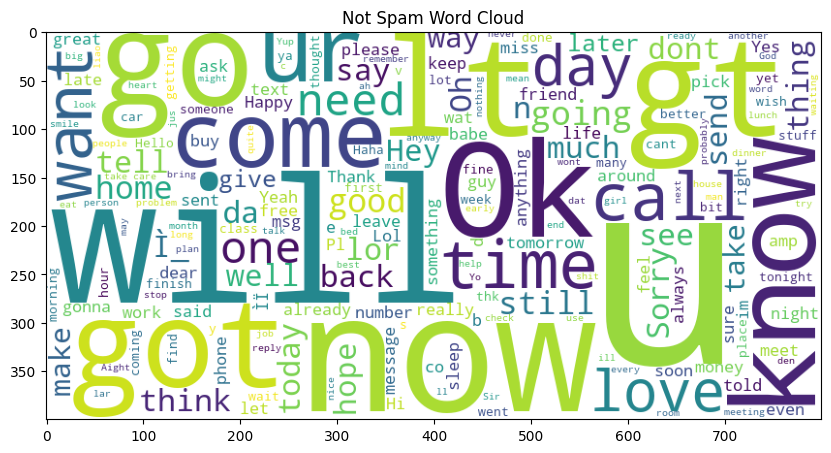

In [73]:
# Ham word cloud
wc = WordCloud(width=800, height=400, max_words=200,min_font_size=10, background_color='white')
ham_wc = wc.generate(' '.join(df[df['label'] == 0]['message']))
plt.figure(figsize=(10, 10))
plt.imshow(ham_wc)
plt.title('Not Spam Word Cloud')
plt.show()

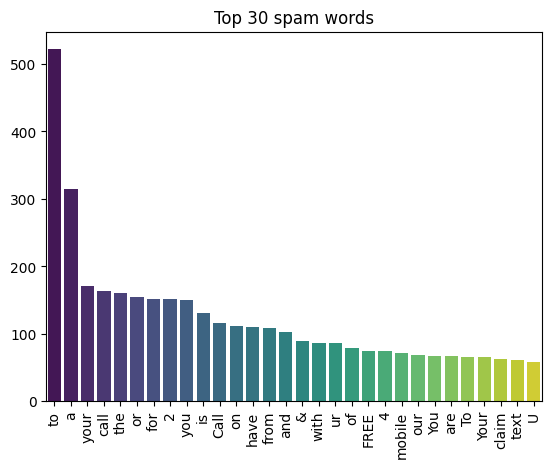

In [74]:
# Top 30 word of spam
spam_words = []
for message in df[df['label'] == 1]['message']:
    for word in message.split():
        spam_words.append(word)

spam_words_count = Counter(spam_words)

sns.barplot(x=[i[0] for i in spam_words_count.most_common(30)], y=[i[1] for i in spam_words_count.most_common(30)], 
            palette='viridis', hue=[i[0] for i in spam_words_count.most_common(30)])
plt.xticks(rotation=90)
plt.title('Top 30 spam words')
plt.show()



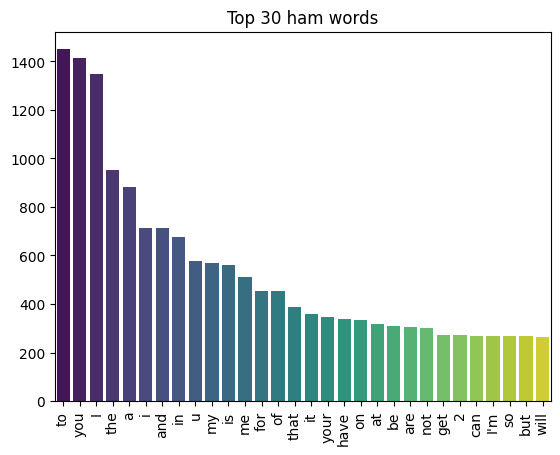

In [75]:
# Top 30 word of ham
ham_words = []
for message in df[df['label'] == 0]['message']:
    for word in message.split():
        ham_words.append(word)

ham_words_count = Counter(ham_words)

sns.barplot(x=[i[0] for i in ham_words_count.most_common(30)], y=[i[1] for i in ham_words_count.most_common(30)],
            palette='viridis', hue=[i[0] for i in ham_words_count.most_common(30)])
plt.xticks(rotation=90)
plt.title('Top 30 ham words')
plt.show()

## Preprocessing of messages

In [76]:
# Check url in the message (just checking)
def check_url(message):
    return bool(re.search('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', message))

for message in df['message']:
    count = 0
    if check_url(message):
        count += 1
    else:
        pass

count

0

In [77]:
# Create stop words set
stop_words = set(stopwords.words('english'))

In [78]:
# Preprocess the text data
def preprocess_text(text, stop_words):
    text = text.lower() # Lowercase the text
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) # Remove url
    text = re.sub(r'[^a-z0-9\s]', '', text) # Remove special characters
    text = re.sub(r'\s+', ' ', text) # Remove extra spaces
    text = ' '.join(word for word in text.split() if word not in stop_words) # Remove stopwords
    text = ''.join([i for i in text if not i.isdigit()]) # remove numerics values
    return text

In [79]:
# Apply the preprocess_text function to the message column
df['message'] = df['message'].apply(lambda x: preprocess_text(x, stop_words))

In [80]:
df.head()

,label,message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts st...
3,0,u dun say early hor u c already say
4,0,nah dont think goes usf lives around though


## Model Building

### Split the data

In [81]:
X = df['message']
y = df['label'].values

In [82]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4135,), (1034,), (4135,), (1034,))

### Text Vectorization

In [83]:
# Initialize the CountVectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_count = count_vectorizer.fit_transform(X_train).toarray()

# Transform the testing data
X_test_count = count_vectorizer.transform(X_test).toarray()

X_train_count.shape, X_test_count.shape

((4135, 7350), (1034, 7350))

In [84]:
# Creat dataframe for the count vectorizer
count_vectorizer_df = pd.DataFrame(X_train_count, columns=count_vectorizer.get_feature_names_out())

count_vectorizer_df

,aa,aah,aaniye,aaooooright,aathiwhere,ab,abbey,abdomen,abeg,abel,...,zealand,zebra,zed,zeros,zhong,zoe,zogtorius,zoom,zouk,zs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4131,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4132,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Multinomial Navie Bayes Model

In [85]:
class MultinomialNaiveBayes:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.class_log_prior_ = None
        self.feature_log_prob_ = None
        self.classes_ = None

    def fit(self, X, y):
        count_sample = X.shape[0]
        self.classes_ = np.unique(y)
        count_classes = len(self.classes_)
        
        # P(y)
        self.class_log_prior_ = np.log(np.bincount(y) / count_sample)
        
        # P(x|y)
        smoothed_class_counts = np.zeros((count_classes, X.shape[1]))
        
        for idx, cls in enumerate(self.classes_):
            smoothed_class_counts[idx, :] = X[y == cls].sum(axis=0) + self.alpha
        
        self.feature_log_prob_ = np.log(smoothed_class_counts / smoothed_class_counts.sum(axis=1).reshape(-1, 1))
        
        return self

    def predict(self, X):
        jll = X @ self.feature_log_prob_.T + self.class_log_prior_
        return self.classes_[np.argmax(jll, axis=1)]
    
    def predict(self, X):
        return np.argmax(self.predict_log_proba(X), axis=1)
    
    def predict_log_proba(self, X):
        return (X @ self.feature_log_prob_.T) + self.class_log_prior_

In [86]:
model = MultinomialNaiveBayes()

model.fit(X_train_count, y_train)

In [87]:
y_pred = model.predict(X_test_count)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.971953578336557

In [88]:
# Tính toán lỗi huấn luyện và lỗi kiểm tra
y_train_pred = model.predict(X_train_count)
y_test_pred = model.predict(X_test_count)

training_error = 1 - accuracy_score(y_train, y_train_pred)
testing_error = 1 - accuracy_score(y_test, y_test_pred)

training_error, testing_error

(0.004111245465538094, 0.028046421663442955)

Text(0.5, 1.0, 'Confusion Matrix')

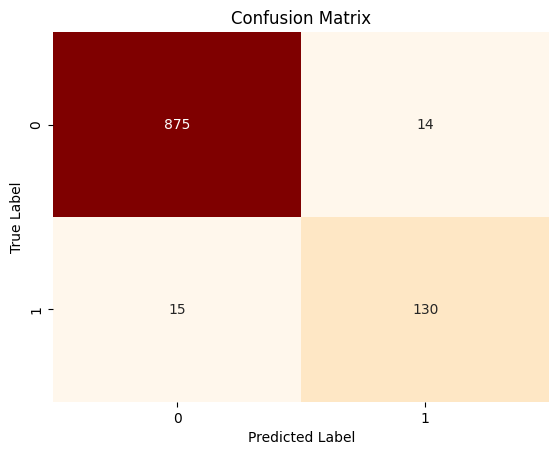

In [89]:
# Visualize the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='OrRd', fmt='d', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

- find out best hyperparameter of Multinomial naive bayes
- plotting alpha vs accuracy plot
- alpha values to try, ranging from 10^-5 to 10^5

In [90]:
alpha_values = np.logspace(-5, 5, 11)

accuracies = []

for alpha in alpha_values:
    model = MultinomialNaiveBayes(alpha=alpha)
    model.fit(X_train_count, y_train)
    y_pred = model.predict(X_test_count)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

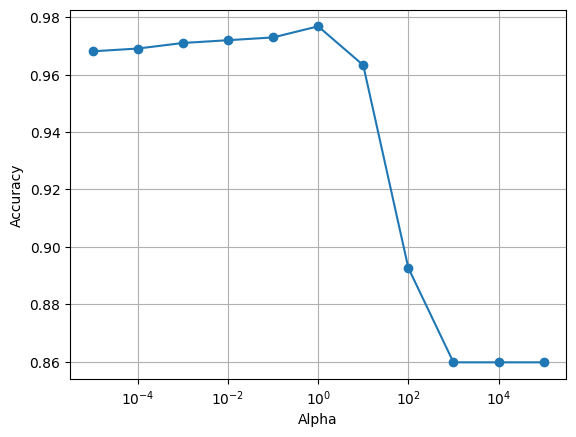

In [91]:
plt.plot(alpha_values, accuracies, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [92]:
# find the best alpha value
best_alpha = alpha_values[np.argmax(accuracies)]
best_alpha

1.0

In [93]:
model = MultinomialNaiveBayes(alpha=best_alpha)
model.fit(X_train_count, y_train)

In [100]:
# accuracy
y_pred = model.predict(X_test_count)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.97678916827853

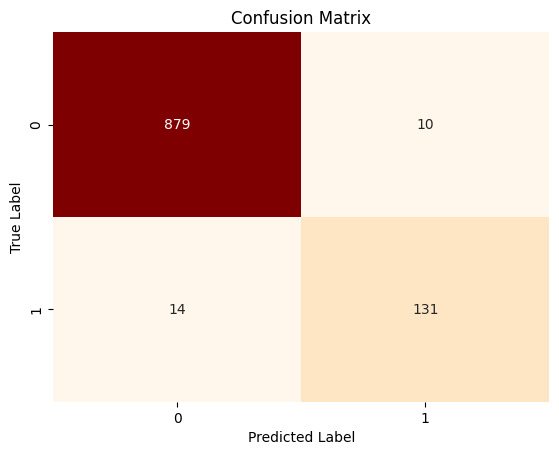

In [99]:
# confusion matrix
y_pred = model.predict(X_test_count)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='OrRd', fmt='d', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [94]:
message = ['Congratulations! You have won a lottery ticket worth $1 million. Please click the link to claim your prize.']

message = [preprocess_text(message[0], stop_words)]

message_count = count_vectorizer.transform(message).toarray()

model.fit(X_train_count, y_train)

y_pred = model.predict(message_count)

y_pred

array([1], dtype=int64)

In [95]:
mnb_model = MultinomialNB(alpha=0.01)
mnb_model.fit(X_train_count, y_train)
mnb_pred = mnb_model.predict(X_test_count)
mnb_pred

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

### Save model

In [98]:
# save the MultinomialNB model
with open('./models/mnb_model.pkl', 'wb') as file:
    pkl.dump(mnb_model, file)

# save the count vectorizer
with open('./models/count_vectorizer.pkl', 'wb') as file:
    pkl.dump(count_vectorizer, file)